# BONUS 1. (2 балла) 
### Variational Autoencoder

Если вы (надеюсь) осознали, в каком месте у conditional AE выше могли бы быть проблемы, то -- тадам!!

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [103]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image

from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)
num_classes = y_test_cat.shape[1]

image_H      = x_train.shape[1]
image_W      = x_train.shape[2]
channels     = x_train.shape[3]
original_dim = image_H * image_W * channels
hidden_layer = 256
latent_dim   = 64
dropout_rate = 0.2
batch_size   = 250
epoch        = 500
lr           = 1e-3
epsilon_std  = 1.0

In [104]:
# fix randoms

rnd = 383

import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'
from numpy.random import seed
seed(rnd)
import random
random.seed(rnd)
# seed(rnd)
# from tensorflow import set_random_seed
# set_random_seed(rnd)

In [105]:
from scipy.stats import norm

def plot_gallery(images, h, w, n_row=23, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [106]:
# Функция отрисовки цифр

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [107]:
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.models import Model
from keras.utils import plot_model

from keras.losses import mse, binary_crossentropy
from keras.optimizers import Adam
from keras import backend as K          # define the custom loss through backend
from keras.callbacks import EarlyStopping

import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

In [108]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [109]:
def create_vae():

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(shape=(image_H, image_W, channels), name='encoder_input')
    x = Flatten()(input_img)
    x = Dense(hidden_layer, activation='elu')(x)
    x = apply_bn_and_dropout(x)

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Сэмплирование из Q с трюком репараметризации
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z_layer = Lambda(sampling, output_shape=(latent_dim,), name='z_layer')([z_mean, z_log_var])

    # Декодер
    input_lat = Input(shape=(latent_dim,))
    x = Dense(hidden_layer, activation='elu')(input_lat)
    x = apply_bn_and_dropout(x)
    x = Dense(original_dim, activation='sigmoid')(x)
    decoded = Reshape((image_H, image_W, channels))(x)

    # модели
    encoder = Model(input_img, z_layer, name='encoder')
    print(encoder.summary())
    plot_model(encoder, to_file='vae_encoder.png', show_shapes=True)
    decoder = Model(input_lat, decoded, name='decoder')
    print(decoder.summary())
    # plot_model(decoder, to_file='vae_decoder.png', show_shapes=True)
    
#     decoded = decoder(encoder(input_img)[0])
    autoencoder = Model(input_img, decoder(encoder(input_img)), name='autoencoder')
    print(autoencoder.summary())
    # plot_model(autoencoder, to_file='vae_autoencoder.png', show_shapes=True)
    
    return encoder, decoder, autoencoder

In [110]:
var_encoder, var_decoder, var_autoencoder = create_vae()

def vae_loss(y_true, y_pred):
    reconstruction_loss = keras.losses.mean_squared_error(y_true, y_pred)       # keras.losses.mean_squared_error
    reconstruction_loss *= original_dim
    z_mean = var_autoencoder.get_layer('encoder').get_layer('z_mean').output
    z_log_var = var_autoencoder.get_layer('encoder').get_layer('z_log_var').output
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

var_autoencoder.compile(optimizer=Adam(lr), loss=vae_loss, metrics=['accuracy'])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 256)          200960      flatten_9[0][0]                  
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 256)          1024        dense_25[0][0]                   
____________________________________________________________________________________________

И обучим модель:

In [111]:
history = var_autoencoder.fit(x_train, x_train, shuffle=False,
                              epochs=epoch,
                              batch_size=batch_size,
                              validation_data=(x_test, x_test),
                              verbose=2,
                              callbacks = [EarlyStopping(patience = 5)])
var_autoencoder.save_weights('vae_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
 - 86s - loss: 301.0812 - accuracy: 0.7262 - val_loss: 151.6404 - val_accuracy: 0.8038
Epoch 2/500
 - 81s - loss: 154.7497 - accuracy: 0.8057 - val_loss: 135.8140 - val_accuracy: 0.8079
Epoch 3/500
 - 82s - loss: 143.9765 - accuracy: 0.8074 - val_loss: 129.3507 - val_accuracy: 0.8088
Epoch 4/500
 - 81s - loss: 137.1892 - accuracy: 0.8085 - val_loss: 124.6127 - val_accuracy: 0.8090
Epoch 5/500
 - 82s - loss: 133.0844 - accuracy: 0.8090 - val_loss: 122.4700 - val_accuracy: 0.8093
Epoch 6/500
 - 80s - loss: 130.8158 - accuracy: 0.8093 - val_loss: 119.8295 - val_accuracy: 0.8096
Epoch 7/500
 - 80s - loss: 129.2651 - accuracy: 0.8095 - val_loss: 118.5148 - val_accuracy: 0.8097
Epoch 8/500
 - 80s - loss: 128.1308 - accuracy: 0.8096 - val_loss: 117.4226 - val_accuracy: 0.8099
Epoch 9/500
 - 83s - loss: 127.2173 - accuracy: 0.8097 - val_loss: 116.4733 - val_accuracy: 0.8102
Epoch 10/500
 - 78s - loss: 126.4729 - accuracy: 0.8098 - v

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


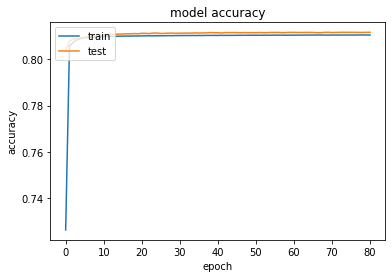

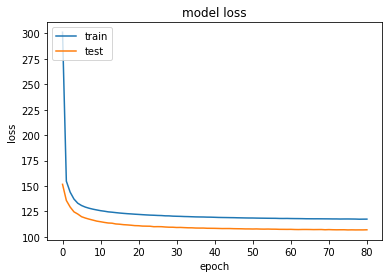

In [112]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

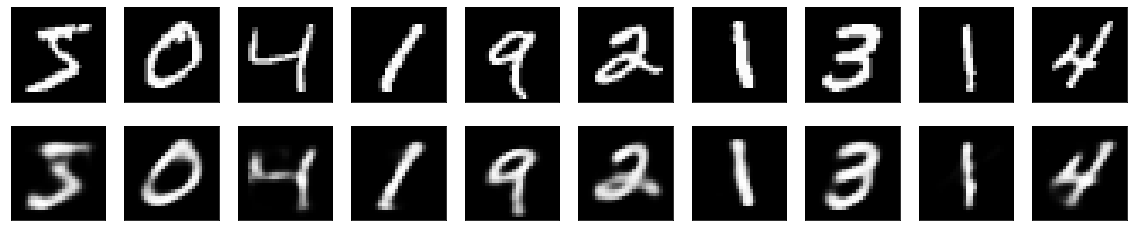

In [113]:
n = 10
imgs = x_train[:n]

v_ae_gen_imgs = var_autoencoder.predict(imgs, batch_size=n)

plot_digits(imgs, v_ae_gen_imgs)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие лица получатся:

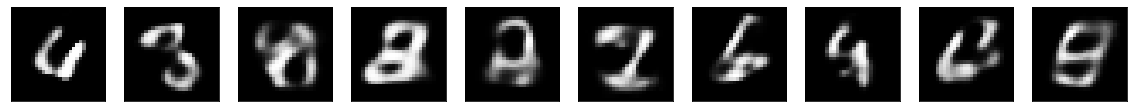

In [114]:
# вспомните про замечание из этого же ункта обычного AE про распределение латентных переменных
zz = np.array([np.random.normal(0, 1, latent_dim) for i in range(n)])

output = var_decoder.predict(zz)
for i in range(n//10):
    plot_digits(output[i*10:(i*10)+10])

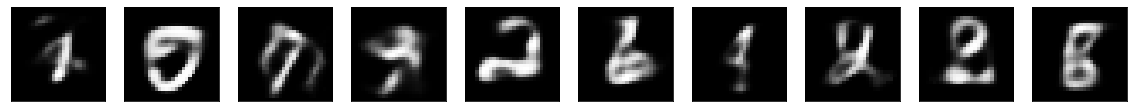

In [115]:
n = 10
z = np.random.randn(n, latent_dim)
output = var_decoder.predict(z)
for i in range(n//10):
    plot_digits(output[i*10:(i*10)+10])

In [15]:
# from scipy.stats import norm

# # display a 2D manifold of the digits
# n = 15  # figure with 15x15 digits
# digit_size = 28

# # linearly spaced coordinates on the unit square were transformed
# # through the inverse CDF (ppf) of the Gaussian to produce values
# # of the latent variables z, since the prior of the latent space
# # is Gaussian

# z1 = norm.ppf(np.linspace(0.01, 0.99, n))
# z2 = norm.ppf(np.linspace(0.01, 0.99, n))
# z_grid = np.dstack(np.meshgrid(z1, z2))

# x_pred_grid = var_decoder.predict(z_grid.reshape(n*n, latent_dim)).reshape(n, n, digit_size, digit_size)

# plt.figure(figsize=(10, 10))
# plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
# plt.show()

In [116]:
# получим latent_space со всего датасета

vae_latent_space = var_encoder.predict(x_train)#[2]

In [117]:
from sklearn.manifold import TSNE
vae_latent_embedded = TSNE(n_components=2).fit_transform(vae_latent_space)
vae_latent_embedded.shape

(60000, 2)

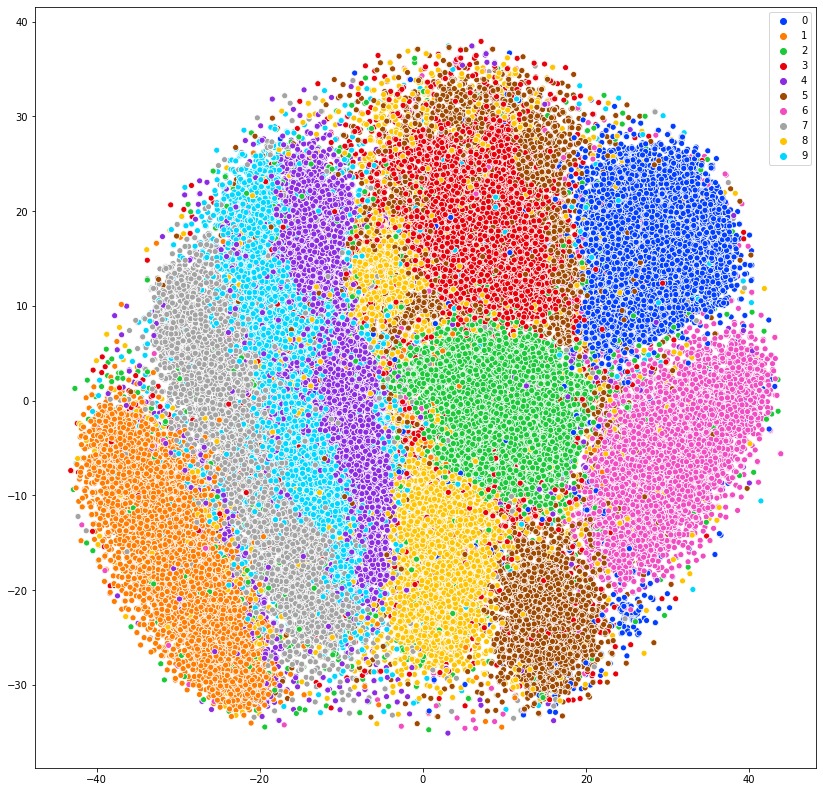

In [118]:
import seaborn as sns

plt.figure(figsize=(14, 14))
sns.scatterplot(x=vae_latent_embedded[:, 1], y=vae_latent_embedded[:, 0],
                hue=y_train, palette=sns.color_palette("bright", 10));

## Congrats v2.0!

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера